# Import libraries

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
from glob import glob

# Read data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Get path for data from Google Drive
mask_dir = '/content/drive/My Drive/281Project/raw_data/archive-2-segmentation-masks/masks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_image(image_path):
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Symmetry Score Functions

In [ ]:
def calculate_symmetry_score_y_axis(segmentation_mask):
    # Ensure binary image: lesion = 1 (white), background = 0 (black)
    _, binary_mask = cv2.threshold(segmentation_mask, 127, 1, cv2.THRESH_BINARY)

    # Find contours of the lesion
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0.0

    # Get the bounding box of the largest contour
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the region containing the lesion
    region = binary_mask[y:y+h, x:x+w]

    # Split the region into left and right halves
    midline = w // 2
    left_half = region[:, :midline]
    right_half = region[:, midline:]

    # Flip the right half to compare with the left half
    right_half_flipped = cv2.flip(right_half, 1)

    # Calculate the overlap between the left half and the flipped right half
    min_width = min(left_half.shape[1], right_half_flipped.shape[1])
    left_half = left_half[:, :min_width]
    right_half_flipped = right_half_flipped[:, :min_width]

    overlap = np.sum(left_half == right_half_flipped)
    total_pixels = np.sum(region)

    if total_pixels == 0:
        return 0.0

    symmetry_score = overlap / total_pixels
    return symmetry_score

In [ ]:
def calculate_symmetry_score_x_axis(segmentation_mask):
    # Ensure binary image: lesion = 1 (white), background = 0 (black)
    _, binary_mask = cv2.threshold(segmentation_mask, 127, 1, cv2.THRESH_BINARY)

    # Find contours of the lesion
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0.0

    # Get the bounding box of the largest contour
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the region containing the lesion
    region = binary_mask[y:y+h, x:x+w]

    # Split the region into top and bottom halves
    midline = h // 2
    top_half = region[:midline, :]
    bottom_half = region[midline:, :]

    # Flip the bottom half to compare with the top half
    bottom_half_flipped = cv2.flip(bottom_half, 0)

    # Calculate the overlap between the top half and the flipped bottom half
    min_height = min(top_half.shape[0], bottom_half_flipped.shape[0])
    top_half = top_half[:min_height, :]
    bottom_half_flipped = bottom_half_flipped[:min_height, :]

    overlap = np.sum(top_half == bottom_half_flipped)
    total_pixels = np.sum(region)

    if total_pixels == 0:
        return 0.0

    symmetry_score = overlap / total_pixels
    return symmetry_score

In [ ]:
def calculate_symmetry_score_main_diagonal(segmentation_mask):
    # Ensure binary image: lesion = 1 (white), background = 0 (black)
    _, binary_mask = cv2.threshold(segmentation_mask, 127, 1, cv2.THRESH_BINARY)

    # Find contours of the lesion
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0.0

    # Get the bounding box of the largest contour
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the region containing the lesion
    region = binary_mask[y:y+h, x:x+w]

    # Calculate the overlap for the main diagonal (y=x line)
    overlap = 0
    total_pixels = 0

    min_dim = min(h, w)
    for i in range(min_dim):
        for j in range(min_dim):
            if region[i, j] == 1:
                total_pixels += 1
                # Ensure indices are within bounds
                if i < h and j < w and region[j, i] == region[i, j]:
                    overlap += 1

    if total_pixels == 0:
        return 0.0

    symmetry_score = overlap / total_pixels
    return symmetry_score

In [ ]:
def calculate_symmetry_score_anti_diagonal(segmentation_mask):
    # Ensure binary image: lesion = 1 (white), background = 0 (black)
    _, binary_mask = cv2.threshold(segmentation_mask, 127, 1, cv2.THRESH_BINARY)

    # Find contours of the lesion
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0.0

    # Get the bounding box of the largest contour
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the region containing the lesion
    region = binary_mask[y:y+h, x:x+w]

    # Calculate the overlap for the anti-diagonal (y=-x line)
    overlap = 0
    total_pixels = 0

    for i in range(h):
        for j in range(w):
            if region[i, j] == 1:
                total_pixels += 1
                # Ensure indices are within bounds
                if h - j - 1 >= 0 and h - j - 1 < h and w - i - 1 >= 0 and w - i - 1 < w:
                    if region[h - j - 1, w - i - 1] == region[i, j]:
                        overlap += 1

    if total_pixels == 0:
        return 0.0

    symmetry_score = overlap / total_pixels
    return symmetry_score

In [ ]:
def calculate_combined_symmetry_score(segmentation_mask):
    symmetry_score_y = calculate_symmetry_score_y_axis(segmentation_mask)
    symmetry_score_x = calculate_symmetry_score_x_axis(segmentation_mask)
    symmetry_score_main_diagonal = calculate_symmetry_score_main_diagonal(segmentation_mask)
    symmetry_score_anti_diagonal = calculate_symmetry_score_anti_diagonal(segmentation_mask)
    combined_score = (symmetry_score_y + symmetry_score_x + symmetry_score_main_diagonal + symmetry_score_anti_diagonal) / 4
    return combined_score

# Extract symmetry score feature

In [ ]:
# Store symmetry scores for all images
symmetry_scores = []

# Images are in a directory and follow a naming convention
image_paths = glob(os.path.join(mask_dir, '*.png'))

# Loop through images in directory and calculate symmetry score for each
for image_path in image_paths:
    segmentation_mask = load_image(image_path)
    score = calculate_combined_symmetry_score(segmentation_mask)
    symmetry_scores.append(score)

In [ ]:
# Save the scores to a data frame
image_names = [os.path.basename(path).split('_segmentation')[0] for path in image_paths]
symmetry_df = pd.DataFrame({'image_id': image_names, 'symmetry_score': symmetry_scores})

# EDA

In [ ]:
# View data
symmetry_df

,image_id,symmetry_score
0,ISIC_0034314,0.665102
1,ISIC_0033288,0.672085
2,ISIC_0033053,0.760136
3,ISIC_0032842,0.734827
4,ISIC_0032793,0.753253
...,...,...
10010,ISIC_0024857,0.519083
10011,ISIC_0025691,0.609247
10012,ISIC_0026302,0.742228
10013,ISIC_0025986,0.665681


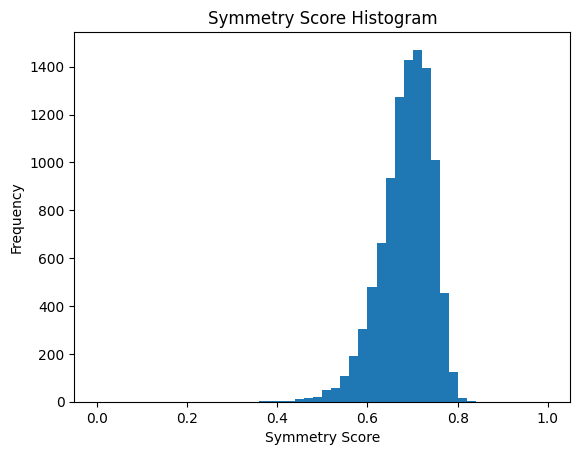

In [ ]:
# Plot histogram
plt.hist(symmetry_df['symmetry_score'], bins=50, range=(0,1))
plt.title('Symmetry Score Histogram')
plt.xlabel('Symmetry Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Read image metadata
metadata_path = '/content/drive/My Drive/281Project/raw_data/archive-2-metadata/HAM10000_metadata.csv'
metadata_df = pd.read_csv(metadata_path)

# Merge data on image_id column
merged_df = pd.merge(symmetry_df, metadata_df, on='image_id', how='inner')

# View merged data
merged_df

,image_id,symmetry_score,lesion_id,dx,dx_type,age,sex,localization
0,ISIC_0034314,0.665102,HAM_0006042,nv,histo,50.0,male,abdomen
1,ISIC_0033288,0.672085,HAM_0000578,nv,histo,30.0,female,back
2,ISIC_0033053,0.760136,HAM_0003236,nv,consensus,30.0,female,upper extremity
3,ISIC_0032842,0.734827,HAM_0007101,bkl,histo,60.0,male,lower extremity
4,ISIC_0032793,0.753253,HAM_0002074,nv,consensus,40.0,female,face
...,...,...,...,...,...,...,...,...
10010,ISIC_0024857,0.519083,HAM_0004360,nv,consensus,30.0,male,foot
10011,ISIC_0025691,0.609247,HAM_0000065,bcc,histo,50.0,female,abdomen
10012,ISIC_0026302,0.742228,HAM_0003751,nv,follow_up,55.0,female,genital
10013,ISIC_0025986,0.665681,HAM_0006123,bkl,histo,70.0,female,back


In [ ]:
# Find most symmetrical
most_symmetrical_df = merged_df.nlargest(10, 'symmetry_score')
most_symmetrical_df

,image_id,symmetry_score,lesion_id,dx,dx_type,age,sex,localization
9432,ISIC_0026670,0.822683,HAM_0006916,nv,histo,80.0,female,upper extremity
1675,ISIC_0033333,0.816309,HAM_0006445,mel,histo,60.0,female,lower extremity
6524,ISIC_0027586,0.815546,HAM_0001421,nv,follow_up,45.0,female,trunk
8640,ISIC_0025778,0.809757,HAM_0000609,nv,histo,75.0,female,upper extremity
7915,ISIC_0025990,0.807262,HAM_0000609,nv,histo,75.0,female,upper extremity
4348,ISIC_0032189,0.805582,HAM_0006028,nv,histo,40.0,male,chest
8041,ISIC_0026981,0.804832,HAM_0000909,akiec,histo,55.0,male,lower extremity
5016,ISIC_0030515,0.803725,HAM_0004361,nv,follow_up,45.0,male,foot
992,ISIC_0032923,0.803620,HAM_0005353,nv,consensus,30.0,male,back
4465,ISIC_0029168,0.802849,HAM_0003147,nv,follow_up,50.0,female,trunk


In [ ]:
# Find most asymmetrical
most_asymmetrical_df = merged_df.nsmallest(10, 'symmetry_score')
most_asymmetrical_df

,image_id,symmetry_score,lesion_id,dx,dx_type,age,sex,localization
9061,ISIC_0025898,0.362873,HAM_0002332,nv,consensus,0.0,male,foot
7362,ISIC_0025349,0.370094,HAM_0006139,nv,follow_up,50.0,male,trunk
1228,ISIC_0030916,0.376794,HAM_0006642,nv,follow_up,50.0,male,trunk
7448,ISIC_0025670,0.386567,HAM_0002332,nv,consensus,0.0,male,foot
6670,ISIC_0031180,0.399405,HAM_0002612,nv,follow_up,35.0,male,abdomen
7616,ISIC_0024460,0.406220,HAM_0007135,nv,follow_up,50.0,female,neck
6464,ISIC_0031280,0.410248,HAM_0004843,nv,follow_up,60.0,male,foot
6477,ISIC_0029923,0.412333,HAM_0000870,nv,follow_up,50.0,male,trunk
4053,ISIC_0030078,0.421242,HAM_0005796,nv,follow_up,50.0,female,upper extremity
9298,ISIC_0024576,0.424157,HAM_0003936,nv,follow_up,35.0,female,lower extremity


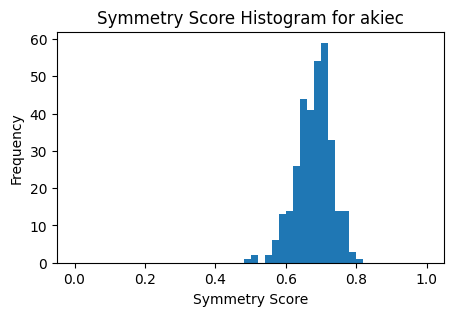

Statistics for akiec:
Number of Rows: 327
Mean Symmetry Score: 0.68
Median Symmetry Score: 0.68
Standard Deviation: 0.05




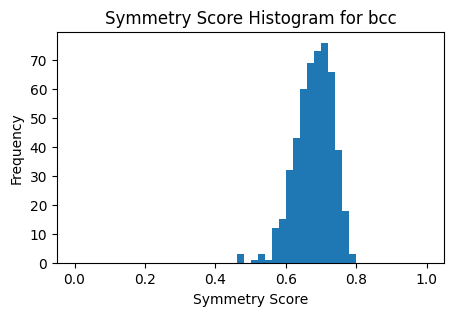

Statistics for bcc:
Number of Rows: 514
Mean Symmetry Score: 0.68
Median Symmetry Score: 0.69
Standard Deviation: 0.05




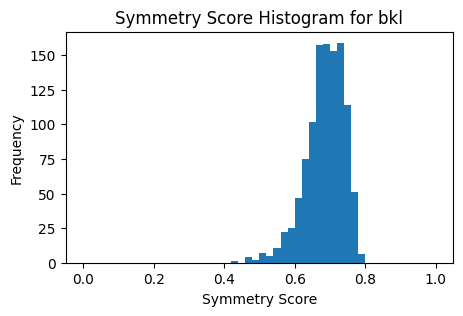

Statistics for bkl:
Number of Rows: 1099
Mean Symmetry Score: 0.69
Median Symmetry Score: 0.69
Standard Deviation: 0.06




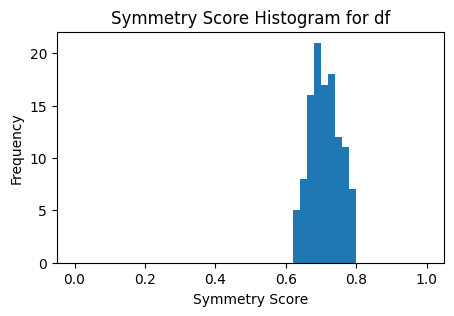

Statistics for df:
Number of Rows: 115
Mean Symmetry Score: 0.71
Median Symmetry Score: 0.71
Standard Deviation: 0.04




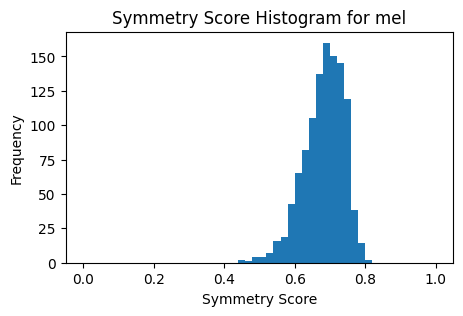

Statistics for mel:
Number of Rows: 1113
Mean Symmetry Score: 0.68
Median Symmetry Score: 0.69
Standard Deviation: 0.06




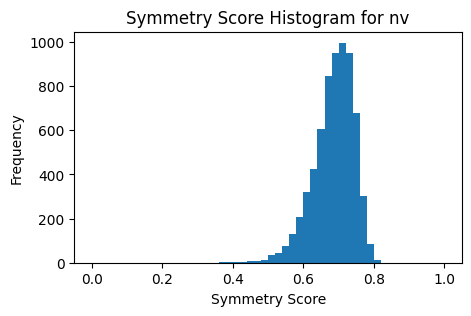

Statistics for nv:
Number of Rows: 6705
Mean Symmetry Score: 0.69
Median Symmetry Score: 0.69
Standard Deviation: 0.06




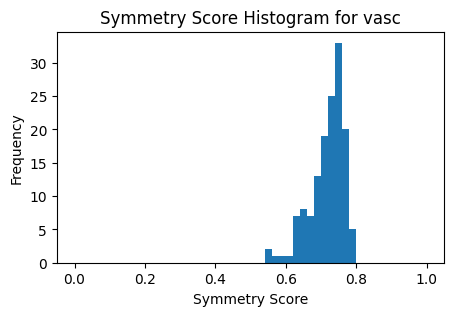

Statistics for vasc:
Number of Rows: 142
Mean Symmetry Score: 0.72
Median Symmetry Score: 0.73
Standard Deviation: 0.05




In [ ]:
# Group by 'dx' and plot histograms
for lesion_type, group in merged_df.groupby('dx'):
    plt.figure(figsize=(5, 3))
    plt.hist(group['symmetry_score'], bins=50, range=(0,1), label=f'Symmetry Score for {lesion_type}')
    plt.title(f'Symmetry Score Histogram for {lesion_type}')
    plt.xlabel('Symmetry Score')
    plt.ylabel('Frequency')
    plt.show()

    # Output statistics
    num_rows = group.shape[0]
    mean_score = group['symmetry_score'].mean()
    median_score = group['symmetry_score'].median()
    std_dev = group['symmetry_score'].std()

    print(f'Statistics for {lesion_type}:')
    print(f'Number of Rows: {num_rows}')
    print(f'Mean Symmetry Score: {mean_score:.2f}')
    print(f'Median Symmetry Score: {median_score:.2f}')
    print(f'Standard Deviation: {std_dev:.2f}')
    print('\n')


# Export symmetry feature data to CSV

In [ ]:
#csv_path = '/content/drive/My Drive/281Project/Model Output Data/symmetry_feature.csv'
#symmetry_df.to_csv(csv_path, index=False)